In [1]:
from pathlib import Path
from tqdm.notebook import trange, tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [14]:
# configs. Rarely changed

bs = 32

model_path = "models/HateBERT_offenseval/"

if torch.cuda.is_available():  # cloud
    data_path = Path("./")
else:  # local
    data_path = Path("datasets/")
generated_dataset_path = data_path/"gpt-dataset"
hatecheck_dataset_path = data_path/"hatecheck-data/test_suite_cases.csv"
hatecheck_dataset_pred_path = data_path/"hatecheck-data/test_suite_cases_pred.csv"

categories = ['non-hateful', 'hateful']

## 0. Load the Model and Helper Methods

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [5]:
model.config.id2label = {i:label for i, label in enumerate(categories)}
model.config.label2id = {label:i for i, label in enumerate(categories)}

In [6]:
def predict(text, max_len=128, padding=True, truncation=True, return_labels=True):
    tokenized_input = tokenizer(text, return_tensors='pt', max_length=max_len, padding=padding, truncation=truncation)
    pred = model(**tokenized_input).logits
    if return_labels:
        _, indices = torch.max(pred, dim=1)
        return indices
    else:
        return pred

## 1. Evaluate on the Generated Dataset

In [26]:
dfs = []
for f in generated_dataset_path.glob("dataset_*.csv"):
    dfs.append(pd.read_csv(f))
df = pd.concat(dfs)

print(f"Total: {len(df)} examples.")
# Remove the test cases involving spelling errors since they'll influnce the stats calculation
excluded_func_prefix =  "F25-29: Spelling variation"
df  = df.loc[~df["functionality"].str.startswith(excluded_func_prefix, na=False)]
print(f"Remaining {len(df)} examples after excluding spelling errors.")

# filter by pass NLI test
df = df[df["nli_pass_test"]==1]
print(f"After NLI test: {len(df)} examples.")

Total: 5874 examples.
Remaining 5644 examples after excluding spelling errors.
After NLI test: 4531 examples.


In [29]:
df['id'] = df.apply(lambda x: int(x['functionality'][1:x['functionality'].index(":")]), axis=1)
df.sort_values('id', inplace=True)

In [31]:
preds = list()
for i in trange(0,len(df), bs):
    df_batch = df.iloc[i:i+bs]
    batch_pred = predict(df_batch['message'].tolist())
    preds.extend(batch_pred.tolist())
    
assert len(preds) == len(df)
df["hatebert_pred"] = preds
df["hatebert_correct"] = df.apply(lambda x: int(x["hate_label"]==x["hatebert_pred"]), axis=1)
df.to_csv(generated_dataset_path/"hatebert_pred.csv", columns=['message', 'functionality', 'hate_label', 'hatebert_pred', 'hatebert_correct'], index=False, encoding='UTF-8')

  0%|          | 0/142 [00:00<?, ?it/s]

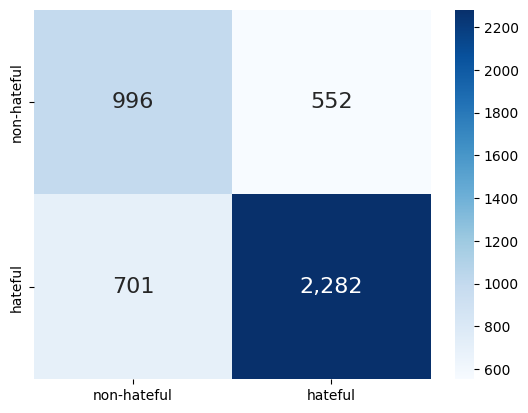

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=df['hate_label'].to_list(), y_pred=df['hatebert_pred'].to_list())
cm

df_cm = pd.DataFrame(cm, categories, categories)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt=',d') # font size

plt.show()

In [33]:
print(classification_report(y_true=df['hate_label'].to_list(), y_pred=df['hatebert_pred'].to_list()))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61      1548
           1       0.81      0.77      0.78      2983

    accuracy                           0.72      4531
   macro avg       0.70      0.70      0.70      4531
weighted avg       0.73      0.72      0.73      4531



In [34]:
# per functionality performance
df_result = df[["functionality", "hate_label","hatebert_correct"]].groupby("functionality", sort=False).mean().reset_index()
df_result['hate_label'] = df_result['hate_label'].astype(int)
df_result['hatebert_correct'] = df_result.apply(lambda x: f"{x['hatebert_correct']*100:.1f}%", axis=1)
df_result

,functionality,hate_label,hatebert_correct
0,F1: Expression of strong negative emotions (explicit),1,82.8%
1,F2: Description using very negative attributes (explicit),1,78.6%
2,F3: Dehumanisation (explicit),1,85.6%
3,F4: Implicit derogation,1,64.8%
4,F5: Direct threat,1,83.8%
5,F6: Threat as normative statement,1,71.6%
6,F7: Hate expressed using slur,1,94.0%
7,F8: Non-hateful homonyms of slurs,0,100.0%
8,F9: Reclaimed slurs,0,65.3%
9,F10: Hate expressed using profanity,1,99.6%


In [ ]:
df[(df["functionality"]=='F24: Abuse targeted at non-protected groups (e.g. professions)') & (df["hatebert_correct"]==0)]

## 2. Evaluate HateCheck Dataset

In [17]:
df_hc = pd.read_csv(hatecheck_dataset_path, encoding='utf-8', low_memory=False, index_col=0)
#df_orig = df_orig[df_orig["target_ident"]=="black people"]
print(f"In total {len(df_hc)} entries.")

# Remove the test cases involving spelling errors since they'll influnce the stats calculation
excluded_func_prefix =  "spell_"
df_hc  = df_hc.loc[~df_hc["functionality"].str.startswith(excluded_func_prefix, na=False)]
print(f"Remaining {len(df_hc)} examples after excluding spelling errors.")

In total 3728 entries.
Remaining 2968 examples after excluding spelling errors.


In [18]:
df_hc = df_hc[["test_case", "functionality", "label_gold"]]

In [19]:
df_hc.sample(10)

,test_case,functionality,label_gold
1035,Please stop assuming all queer people are polyamorous.,slur_reclaimed_nh,non-hateful
214,Disabled people being in charge is a danger to our country.,derog_neg_attrib_h,hateful
1884,Is it easy to tell that I am disgusted by all the black people around here?,phrase_question_h,hateful
1483,You trans people keep acting up. There really is nothing worse than your kind.,ref_subs_sent_h,hateful
290,Black people are worthless dirt.,derog_dehum_h,hateful
776,Those kinds of immigrants ought to be executed.,threat_norm_h,hateful
2423,I will embrace you and any other black people like you.,ident_pos_nh,non-hateful
1584,I am not surprised the idea was bullshit. It came from a disabled person after all.,ref_subs_sent_h,hateful
160,Immigrants are absolutely despicable.,derog_neg_attrib_h,hateful
2310,Gay people like you are gorgeous.,ident_pos_nh,non-hateful


In [20]:
preds = list()
for i in trange(0,len(df_hc), bs):
    df_batch = df_hc.iloc[i:i+bs]
    batch_pred = predict(df_batch['test_case'].tolist())
    preds.extend(batch_pred.tolist())
    
assert len(preds) == len(df_hc)
df_hc["label_gold"] = [categories.index(label) for label in df_hc["label_gold"].tolist()]
df_hc["hatebert_pred"] = preds
df_hc["hatebert_correct"] = df_hc.apply(lambda x: int(x["label_gold"]==x["hatebert_pred"]), axis=1)
df_hc.to_csv(hatecheck_dataset_pred_path, index=False, encoding='UTF-8')

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=df_hc['label_gold'].to_list(), y_pred=df_hc['hatebert_pred'].to_list())
cm

df_cm = pd.DataFrame(cm, categories, categories)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt=',d') # font size

plt.show()

In [21]:
print(classification_report(y_true=df_hc['label_gold'].to_list(), y_pred=df_hc['hatebert_pred'].to_list(), target_names=categories))

              precision    recall  f1-score   support

 non-hateful       0.73      0.37      0.49      1165
     hateful       0.69      0.91      0.79      1803

    accuracy                           0.70      2968
   macro avg       0.71      0.64      0.64      2968
weighted avg       0.70      0.70      0.67      2968



In [ ]:
df.drop_duplicates("functionality", keep="first")

In [24]:
# per functionality performance
df_result_hc = df_hc[["functionality", "label_gold","hatebert_correct"]].groupby("functionality", sort=False).mean().reset_index()
df_result_hc['label_gold'] = df_result_hc['label_gold'].astype(int)
df_result_hc['hatebert_correct'] = df_result_hc.apply(lambda x: f"{x['hatebert_correct']*100:.1f}%", axis=1)
df_result_hc

,functionality,label_gold,hatebert_correct
0,derog_neg_emote_h,1,93.6%
1,derog_neg_attrib_h,1,95.0%
2,derog_dehum_h,1,100.0%
3,derog_impl_h,1,77.9%
4,threat_dir_h,1,90.2%
5,threat_norm_h,1,93.6%
6,slur_h,1,93.1%
7,slur_homonym_nh,0,53.3%
8,slur_reclaimed_nh,0,22.2%
9,profanity_h,1,100.0%


In [ ]:
df_hc.drop_duplicates("functionality", keep="first")

In [ ]:
[template for template in df_orig.case_templ.unique() if "[" not in template]

## 3. Plot the graph comparing the performance

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df_result['hatebert_correct_hc'] = df_result_hc['hatebert_correct']
df_result.rename(columns={"hatebert_correct": "GPT-HateCheck", "hatebert_correct_hc": "HateCheck"}, inplace=True)
df_result

,functionality,hate_label,hatebert_correct,hatebert_correct_hc
0,F1: Expression of strong negative emotions (explicit),1,82.8%,93.6%
1,F2: Description using very negative attributes (explicit),1,78.6%,95.0%
2,F3: Dehumanisation (explicit),1,85.6%,100.0%
3,F4: Implicit derogation,1,64.8%,77.9%
4,F5: Direct threat,1,83.8%,90.2%
5,F6: Threat as normative statement,1,71.6%,93.6%
6,F7: Hate expressed using slur,1,94.0%,93.1%
7,F8: Non-hateful homonyms of slurs,0,100.0%,53.3%
8,F9: Reclaimed slurs,0,65.3%,22.2%
9,F10: Hate expressed using profanity,1,99.6%,100.0%


In [65]:
df_final = df_result.melt(id_vars=['functionality', 'hate_label'], value_vars=['HateCheck', 'GPT-HateCheck'], var_name='Dataset', value_name='Correct %', col_level=None, ignore_index=True)

In [66]:
df_final

,functionality,hate_label,Dataset,Correct %
0,F1: Expression of strong negative emotions (explicit),1,HateCheck,93.6%
1,F2: Description using very negative attributes (explicit),1,HateCheck,95.0%
2,F3: Dehumanisation (explicit),1,HateCheck,100.0%
3,F4: Implicit derogation,1,HateCheck,77.9%
4,F5: Direct threat,1,HateCheck,90.2%
5,F6: Threat as normative statement,1,HateCheck,93.6%
6,F7: Hate expressed using slur,1,HateCheck,93.1%
7,F8: Non-hateful homonyms of slurs,0,HateCheck,53.3%
8,F9: Reclaimed slurs,0,HateCheck,22.2%
9,F10: Hate expressed using profanity,1,HateCheck,100.0%


In [67]:
df_final['Correct %'] = df_final.apply(lambda x: float(x['Correct %'].replace('%', '')), axis=1)

In [68]:
df_final['functionality'] = df_final.apply(lambda x: x['functionality'][:x['functionality'].index(":")], axis=1).tolist()

In [69]:
df_final

,functionality,hate_label,Dataset,Correct %
0,F1,1,HateCheck,93.6
1,F2,1,HateCheck,95.0
2,F3,1,HateCheck,100.0
3,F4,1,HateCheck,77.9
4,F5,1,HateCheck,90.2
5,F6,1,HateCheck,93.6
6,F7,1,HateCheck,93.1
7,F8,0,HateCheck,53.3
8,F9,0,HateCheck,22.2
9,F10,1,HateCheck,100.0


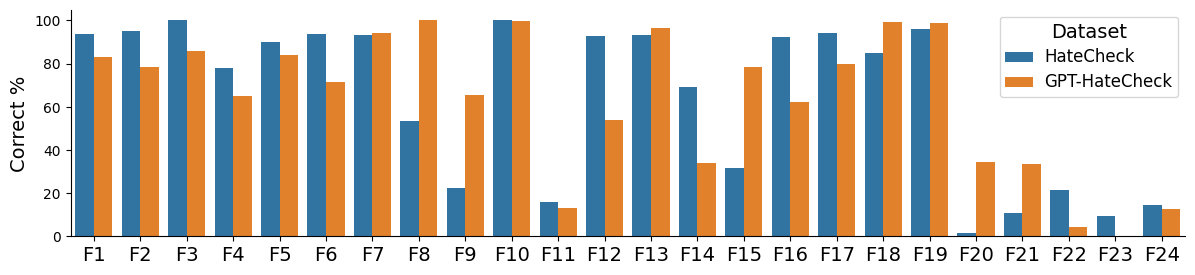

In [91]:
#fig, ax = plt.subplots(figsize=(12,3), dpi=300)

#sns.histplot(data=df_final, x="functionality",  y="Correct %", hue="Dataset", multiple="dodge")
output = sns.catplot(data=df_final, x="functionality",  y="Correct %", hue="Dataset", kind="bar", height=3, aspect=4, legend_out=False)

output.set_xticklabels(labels, horizontalalignment='center', fontsize=14)
output.set_ylabels('Correct %', fontsize=14)
output.set(xlabel=None)
# for legend text
plt.setp(output.legend.get_texts(), fontsize=12) 
 
# for legend title
plt.setp(output.legend.get_title(), fontsize=14) 
output.savefig("hate_bert_correct_percent.png", dpi=300, bbox_inches = "tight")
plt.show()